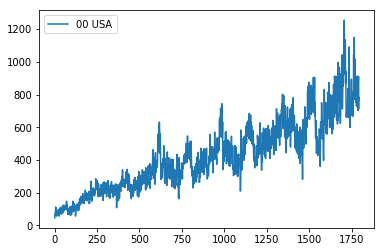

In [1]:
import pandas as pd
%matplotlib inline
df = pd.read_csv('./wifi/application.csv', usecols=[0,1], engine='python', skipfooter=0)
df.plot()

In [2]:
import numpy as np
import pandas as pd
import tflearn
import matplotlib.pyplot as plt
dataframe = pd.read_csv('./wifi/application.csv',
        usecols=[1],
        engine='python',
        skipfooter=0)
dataset = dataframe.values
dataset = dataset.astype('float32')

import copy
original_dataset = copy.deepcopy(dataset)

/Users/kenji/work/sandbox-rnn/tflearn_rnn/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
dataset_min = np.min(np.abs(dataset))
dataset -= dataset_min

dataset_max = np.max(np.abs(dataset))
dataset /= np.max(np.abs(dataset_max))

print('dataset min :', dataset_min)
print('dataset max :', dataset_max)

dataset min : 46.0
dataset max : 1208.0


In [4]:
def create_dataset(dataset, steps_of_history, steps_in_future):
    X, Y = [], []
    for i in range(0, len(dataset)-steps_of_history, steps_in_future):
        X.append(dataset[i:i+steps_of_history])
        Y.append(dataset[i + steps_of_history])
    X = np.reshape(np.array(X), [-1, steps_of_history, 1])
    Y = np.reshape(np.array(Y), [-1, 1])
    return X, Y

def split_data(x, y, test_size=0.1):
    pos = round(len(x) * (1 - test_size))
    trainX, trainY = x[:pos], y[:pos]
    testX, testY   = x[pos:], y[pos:]
    return trainX, trainY, testX, testY

steps_of_history = 1
steps_in_future = 1

X, Y = create_dataset(dataset, steps_of_history, steps_in_future)
trainX, trainY, testX, testY = split_data(X, Y, 0.1)
print(len(testX))
print(len(testY))
# print(testX)
# print(testY)

179
179


In [5]:
net = tflearn.input_data(shape=[None, steps_of_history, 1])
net = tflearn.lstm(net, n_units=6)
# net = tflearn.gru(net, n_units=6, return_seq=True)
# net = tflearn.gru(net, n_units=6)
net = tflearn.fully_connected(net, 1, activation='linear')
net = tflearn.regression(net, optimizer='adam', learning_rate=0.001, loss='mean_square')

model = tflearn.DNN(net, tensorboard_verbose=0)
model.fit(trainX, trainY, validation_set=0.2, batch_size=10, n_epoch=150)

Training Step: 19499  | total loss: 0.00176 | time: 0.566s
| Adam | epoch: 150 | loss: 0.00176 -- iter: 1290/1292
Training Step: 19500  | total loss: 0.00186 | time: 1.587s
| Adam | epoch: 150 | loss: 0.00186 | val_loss: 0.00157 -- iter: 1292/1292
--


In [6]:
testX2 = np.reshape(np.array(testX), [-1, 1, 1])
score = model.evaluate(testX2, testY)
score

[0.00558659217877095]

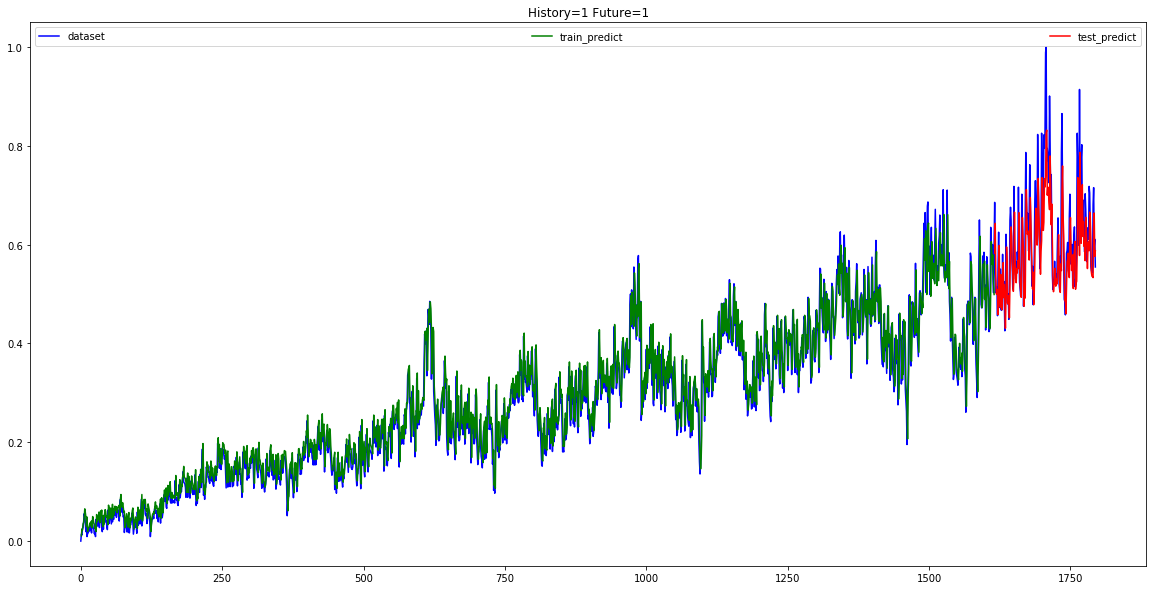

In [7]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

train_predict_plot = np.empty_like(dataset)
train_predict_plot[:, :] = np.nan
train_predict_plot[steps_of_history:len(train_predict)+steps_of_history, :] = train_predict

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict)+steps_of_history:len(dataset), :] = test_predict

plt.figure(figsize=(20, 10))
plt.title('History={} Future={}'.format(steps_of_history, steps_in_future))
plt.plot(dataset, color='blue', label="dataset")
plt.plot(train_predict_plot, color='green', label="train_predict")
plt.plot(test_predict_plot, color='red', label="test_predict")
plt.legend(ncol=3, mode="expand")
plt.savefig('wifi.png')

In [8]:
# train_predict

In [9]:
# dataset

In [10]:
# 平均二乗平方根誤差
def rmse(y_pred, y_true):
    return np.sqrt(((y_true - y_pred) ** 2).mean())

def rmsle(y_pred, y_true):
    return np.sqrt(np.square(np.log(y_true + 1) - np.log(y_pred + 1)).mean())

# 平均絶対誤差
def mae(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred)))

# 平均絶対誤差率
def mape(y_pred, y_true):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [11]:
trainX = np.reshape(np.array(trainX), [-1, 1])
testX = np.reshape(np.array(testX), [-1, 1])
delta = 1e-10

----
### 訓練データ

In [12]:
print(len(trainX))
# print(trainX)

1615


In [13]:
print(len(train_predict))
# print(train_predict)

1615


In [14]:
rmse_train = rmse(train_predict, trainX)

In [15]:
mae_train = mae(train_predict, trainX)

In [16]:
mape_train = mape(train_predict[1:], trainX[1:])

----
### テストデータ

In [17]:
rmse_test = rmse(test_predict, testX)

In [18]:
mae_test = mae(test_predict, testX)

In [19]:
mape_test = mape(test_predict, testX)

----
##### テストデータ 直近のみ

In [20]:
test_predict_last05 = test_predict[1:7]
testX_last05 = testX[1:7]
test_predict_last10 = test_predict[1:10]
testX_last10 = testX[1:10]

In [21]:
rmse_test_last05 = rmse(test_predict_last05, testX_last05)
rmse_test_last10 = rmse(test_predict_last10, testX_last10)

In [22]:
mae_test_last05 = mae(test_predict_last05, testX_last05)
mae_test_last10 = mae(test_predict_last10, testX_last10)

In [23]:
mape_test_last05 = mape(test_predict_last05, testX_last05)
mape_test_last10 = mape(test_predict_last10, testX_last10)

----

In [24]:
print(rmse_train, rmse_test, rmse_test_last10, rmse_test_last05)
print(mae_train, mae_test, mae_test_last10, mae_test_last05)
print(mape_train, mape_test, mape_test_last10, mape_test_last05)

0.010598481 0.04163282 0.017810969 0.018150251
0.00980363 0.029565923 0.012219502 0.011373539
6.596064567565918 4.212697222828865 2.020968310534954 1.8617549911141396


In [34]:
for m in range(0, 3): # 3 months
    m_p = np.concatenate((test_predict[m*4*7:(m+1)*4*7]))
    m_t = np.concatenate((testX[m*4*7:(m+1)*4*7]))
    print('month-%02d' % (m+1), ':', mape(m_p, m_t))
for w in range(0, 3*4): # 3 months * 4 weeks
    w_p = np.concatenate((test_predict[w*7:(w+1)*7]))
    w_t = np.concatenate((testX[w*7:(w+1)*7]))
    print('week-%02d' % (w+1), ':', mape(w_p, w_t))
for d in range(3*4*7): # 3 months * 4 weeks * 7 days
    print('day-%02d' % (d+1), ':', mape(test_predict[d], testX[d]), ':', testX[d], ':', test_predict[d])

month-01 : 1.5045390464365482
month-02 : 3.09279914945364
month-03 : 4.8780471086502075
week-01 : 2.1179543808102608
week-02 : 1.357591338455677
week-03 : 1.1207396164536476
week-04 : 1.42187112942338
week-05 : 3.3899646252393723
week-06 : 3.133291006088257
week-07 : 2.6117777451872826
week-08 : 3.2361626625061035
week-09 : 5.759940296411514
week-10 : 3.5730283707380295
week-11 : 4.718702659010887
week-12 : 5.46051524579525
day-01 : 3.6551516503095627 : [0.60513246] : [0.58301395]
day-02 : 6.196824833750725 : [0.68543047] : [0.64295554]
day-03 : 1.9139330834150314 : [0.54635763] : [0.5359007]
day-04 : 0.7203320041298866 : [0.5033113] : [0.49968576]
day-05 : 0.8317746222019196 : [0.50745034] : [0.5032295]
day-06 : 1.011593360453844 : [0.51407284] : [0.5088725]
day-07 : 0.4960717633366585 : [0.45612583] : [0.45838854]
day-08 : 2.271745353937149 : [0.5587748] : [0.5460809]
day-09 : 4.268655925989151 : [0.625] : [0.5983209]
day-10 : 0.477784825488925 : [0.4942053] : [0.49184406]
day-11 : 0

In [43]:
X, Y = create_dataset(original_dataset, steps_of_history, steps_in_future)
original_trainX, original_trainY, original_testX, original_testY = split_data(X, Y, 0.1)
original_testX2 = np.reshape(np.array(original_testX), [-1, 1])

for m in range(0, 3): # 3 months
    m_p = np.concatenate(test_predict[m*4*7:(m+1)*4*7] * dataset_max + dataset_min)
    m_t = np.concatenate(original_testX2[m*4*7:(m+1)*4*7])
    # print(m_p)
    # print(m_t)
    print('month-%02d' % (m+1), ':', 100-mape(m_p, m_t))
for w in range(0, 3*4): # 3 months * 4 weeks
    w_p = np.concatenate(test_predict[w*7:(w+1)*7] * dataset_max + dataset_min)
    w_t = np.concatenate(original_testX2[w*7:(w+1)*7])
    print('week-%02d' % (w+1), ':', 100-mape(w_p, w_t))
# for d in range(3*4*7): # 3 months * 4 weeks * 7 days
#     print('day-%02d' % (d+1), ':', 100-mape(test_predict[d] * dataset_max + dataset_min, original_testX[d]), ':', np.asscalar(original_testX2[d]), ":", np.asscalar(test_predict[d] * dataset_max + dataset_min))

month-01 : 98.5896073281765
month-02 : 97.08529878407717
month-03 : 95.38180269300938
week-01 : 98.00832848995924
week-02 : 98.72665936127305
week-03 : 98.95605528727174
week-04 : 98.66738570854068
week-05 : 96.80573306977749
week-06 : 97.05027062445879
week-07 : 97.54091519862413
week-08 : 96.94427605718374
week-09 : 94.54380385577679
week-10 : 96.621448174119
week-11 : 95.53728178143501
week-12 : 94.82467770576477


In [42]:
for d in range(3*4*7): # 3 months * 4 weeks * 7 days
    # print('day-%02d' % (d+1), ':',
    #       np.asscalar(original_testX2[d]), ":",
    #       np.asscalar(test_predict[d] * dataset_max + dataset_min), ":",
    #       np.asscalar(testX[d]), ":",
    #       np.asscalar(test_predict[d]))
    print('day-%02d' % (d+1), ':',
          np.asscalar(original_testX2[d]), ":",
          np.asscalar(test_predict[d] * dataset_max + dataset_min))

day-01 : 777.0 : 750.2808837890625
day-02 : 874.0 : 822.6903076171875
day-03 : 706.0 : 693.3680419921875
day-04 : 654.0 : 649.6204223632812
day-05 : 659.0 : 653.9012451171875
day-06 : 667.0 : 660.718017578125
day-07 : 597.0 : 599.7333374023438
day-08 : 721.0 : 705.6657104492188
day-09 : 801.0 : 768.7716674804688
day-10 : 643.0 : 640.1476440429688
day-11 : 617.0 : 617.4615478515625
day-12 : 711.0 : 697.4835205078125
day-13 : 614.0 : 614.8175659179688
day-14 : 610.0 : 611.2837524414062
day-15 : 665.0 : 659.0175170898438
day-16 : 747.0 : 726.6350708007812
day-17 : 644.0 : 641.0118408203125
day-18 : 681.0 : 672.5501708984375
day-19 : 635.0 : 633.2113037109375
day-20 : 560.0 : 566.3216552734375
day-21 : 649.0 : 645.323974609375
day-22 : 796.0 : 764.95068359375
day-23 : 750.0 : 729.026123046875
day-24 : 629.0 : 627.9832763671875
day-25 : 626.0 : 625.361083984375
day-26 : 650.0 : 646.1843872070312
day-27 : 588.0 : 591.6786499023438
day-28 : 677.0 : 669.1821899414062
day-29 : 831.0 : 791.35266

In [28]:
# print(test_predict * dataset_max + dataset_min)
# print(len(test_predict))

In [29]:
X, Y = create_dataset(original_dataset, steps_of_history, steps_in_future)
original_trainX, original_trainY, original_testX, original_testY = split_data(X, Y, 0.1)

# print(len(original_testY))
# print(original_testY)